## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Intro</p>

Hi! This notebook is a part of a bigger _ongoing_ [project](https://github.com/0lekz/mimic-recognition).

The idea behind this project is to build and deploy a fine-tuned **mimic (facial expression) recognition model** capable of detecting my own emotional state, such as **happy, sad, or neutral** from video frames in real-time.


Later, the model will be integrated into a lightweight python script to perform live emotion tracking and potentially trigger certain computer actions.

The **extended version** of the project aims to include **gesture (hand sign) recognition**, allowing real-time control or automation through simple gestures captured via webcam.

---

This notebook serves as the **first experimental stage**, focusing on:
- Understanding and training a model on the **FER2013** facial expression dataset.
- Learning the foundational ideas behind **image preprocessing** and **convolutional neural networks (CNNs)**.
- Building an intuition for how a model interprets raw pixel data into meaningful patterns.
- and more.


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Config</p>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

from cycler import cycler
gruvbox_colors = [
    "#fb4934",  # red
    "#fabd2f",  # yellow
    "#b8bb26",  # green
    "#83a598",  # blue
    "#d3869b",  # purple
    "#fe8019",  # orange
    "#8ec07c",  # aqua
]
rc = {
    "axes.facecolor": "#282828",
    "figure.facecolor": "#282828",
    "axes.edgecolor": "#3c3836",
    "grid.color": "#504945",
    "font.family": "arial",
    "axes.labelcolor": "#ebdbb2",
    "xtick.color": "#d5c4a1",
    "ytick.color": "#d5c4a1",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=gruvbox_colors),
}
sns.set(rc=rc, style="darkgrid")

In [2]:
base_dir = "/kaggle/input/fer2013"
for split in ["train", "test"]:
    print(f"{split} set classes:", os.listdir(os.path.join(base_dir, split)))

train set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
test set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Data Loading</p>

Just wanted to try to go one step further and use Custom PyTorch data pipeline.

I will:

1. Load and preprocess data
2. Include my own augmentation logic
3. Be easy to visualize batches or transformations
4. Prepare the ground for fine-tuning later

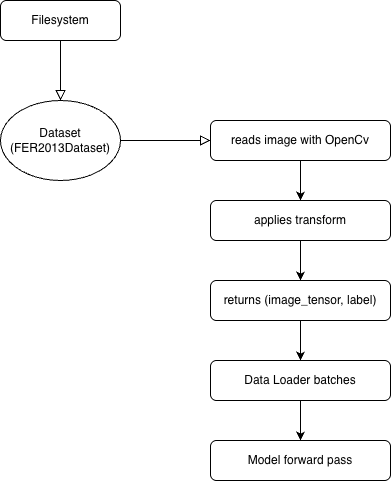
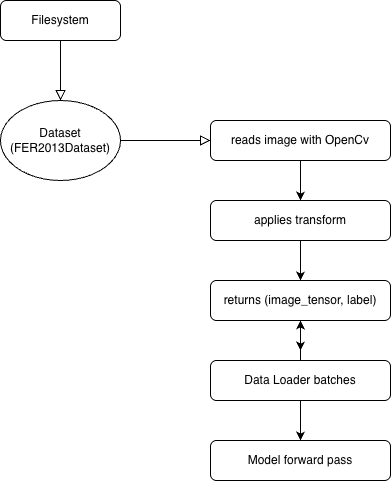

### Custom Dataset Loader

In [3]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    This class provides:
    - Automatic class label mapping (folder name = numeric index)
    - Image loading via OpenCV
    - Optional preprocessing and augmentation via tochvision transform
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + their corresponding numeric labels
        for label, cls in enumerate(self.classes):
            cls_dir = os.path.join(base_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

Now let's build a CustomAugment
Connecting it to the idea of building it production-ready and easy to extend later for full project (my own webcam data) let's think what augmentation we need:

- Rotation: small angles only (since webcam faces are mostly upright)
- Horizontal flips: yes, important to double the data nad simulate mirror orientation
- Brightness variation: realistic for webcam lighting changes
- No need for extreme rotations or zooms - could actually hurt generalization in this case

### Custom Augmentation

In [4]:
class CustomAugment:
    """
    Custom data augmentation tailored for webcam-based face emotion recognition

    It simulates realisitc variations:
        - Small head tilts (rotation)
        - Left/right mirroring
        - Lighting changes (brightness)
    """

    def __init__(self, rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.3):
        self.rotation = rotation
        self.flip_prob = flip_prob
        self.brightness = brightness
        self.brightness_prob = brightness_prob

    def __call__(self, img):
        """
        @input
            img (numpy.ndarray): grayscale img loaded via OpenCV
        @return
            PIL.Image: augmented img
        """
        img = Image.fromarray(img)

        angle = random.uniform(-self.rotation, self.rotation)
        img = transforms.functional.rotate(img, angle)

        if random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)

        if random.random() < self.brightness_prob:
            factor = 1 + random.uniform(-self.brightness, self.brightness)
            img = transforms.functional.adjust_brightness(img, factor)

        return img

### Combine with Normalization and Compose

In [5]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.35),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Quick Visualization

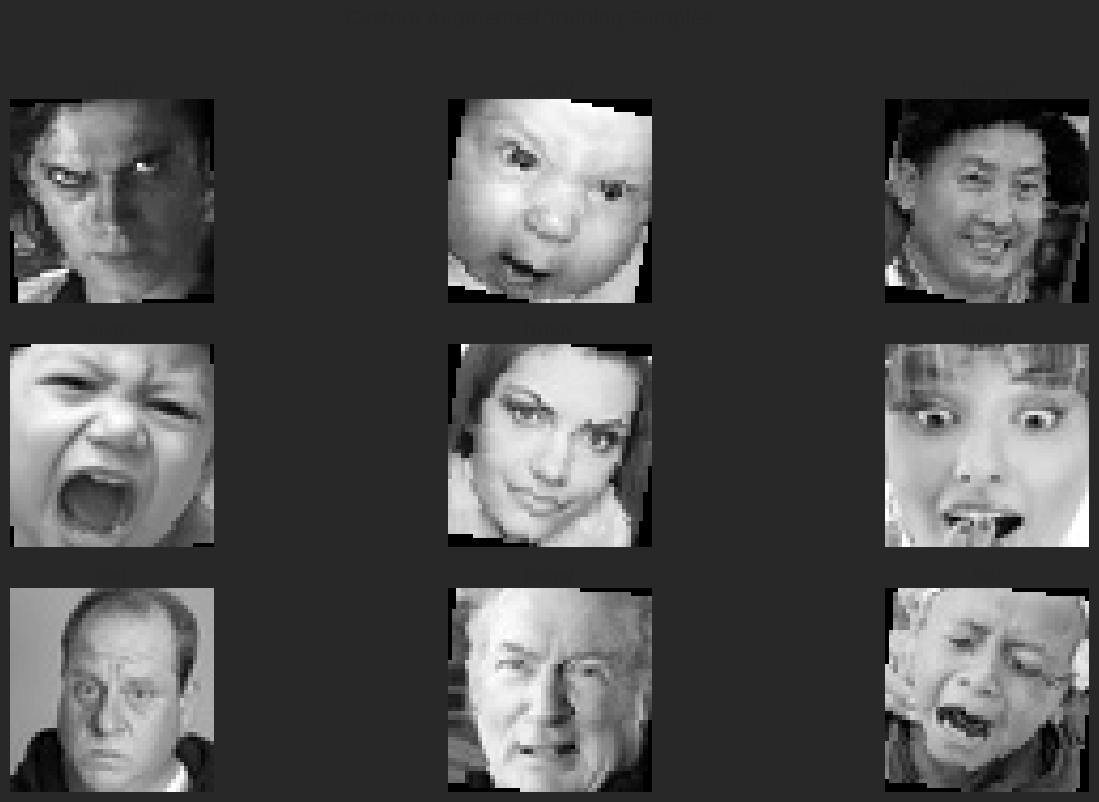

In [6]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True) # wrap it

images, labels = next(iter(train_loader))
images = images * 0.5 + 0.5 # denormalize to [0, 1] for plotting

plt.figure(figsize=(16, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(train_dataset.classes[labels[i]])
    plt.axis('off')

plt.suptitle("Custom Augmented Training Samples", fontsize=14)
plt.show()

### Define Target Emotions

Since I am focusing only on 3 emotions, sad, happy and neutral, I want to remap everything that is not happy or sad into neutral.
That will balance my dataset better and make the model more robust to general expressions.
So let's quickly adjust dataset class accordingly:

In [7]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    We only want three classes to keep for training:
        0: Happy
        1: Sad
        2: Neutral (all other emotions)

    This class provides:
        - Automatic remapping of folder names to numeric labels
        - Image loading via OpenCV
        - Optional preprocessing and augmentation via torchvision transforms
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + remapped labels
        for cls in self.classes:
            cls_dir = os.path.join(base_dir, cls)
            if cls.lower() == "happy":
                label = 0
            elif cls.lower() == "sad":
                label = 1
            else:
                label = 2 # everything else = neutral

            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # resize
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

### Compose Transforms

In [8]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.20, brightness_prob=0.35),
    # could add small extra torchvision augmentations later
    
    transforms.ToTensor(), # PIL -> tensor [C, H, W], scales [0..255] -> [0..1]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Instantiate Dataset and Loaders

In [9]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
test_dataset = FER2013Dataset('/kaggle/input/fer2013/test',  transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 28709
Test size: 7178


Labels in this batch:
['Happy', 'Neutral', 'Neutral', 'Sad', 'Sad', 'Neutral', 'Neutral', 'Sad', 'Happy']


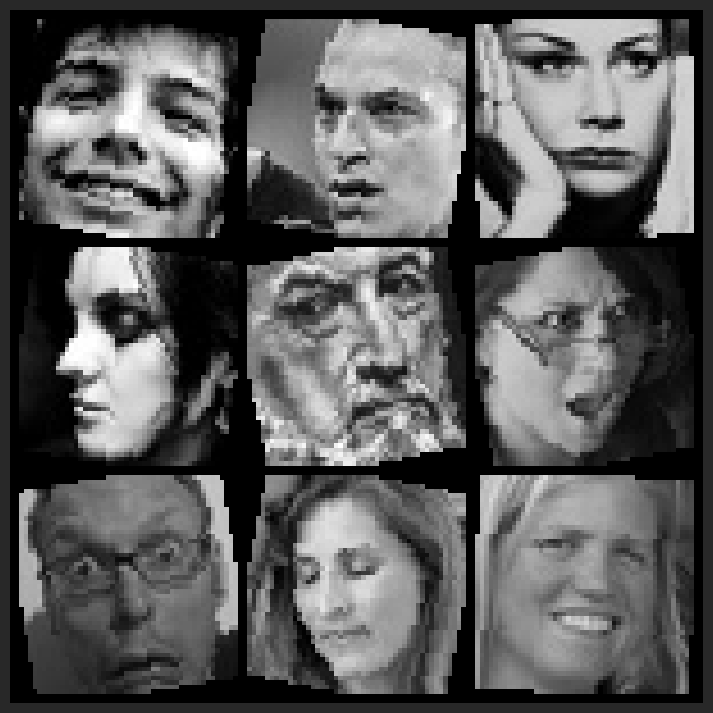

In [10]:
# Remapped label names
label_names = ["Happy", "Sad", "Neutral"]

def show_augmented_batch(loader, n=9):
    # grab first batch
    images, labels = next(iter(loader))
    
    images = images * 0.5 + 0.5  # denormalize to [0,1]

    # pick first n images and labels
    images = images[:n]
    labels = labels[:n]

    grid = torchvision.utils.make_grid(images, nrow=int(n**0.5), normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(grid.permute(1,2,0).squeeze())
    plt.axis('off')

    # print labels below grid
    print("Labels in this batch:")
    print([label_names[label.item()] for label in labels])

    plt.show()

# Show a batch
show_augmented_batch(train_loader, n=9)

This approach is not perfect, but I feel like it will work for our usecase

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Build Model</p>

Facial Expression Recognition (FER) is a common task in computer vision, and architectures have evolved significantly over the past decade. Modern solutions vary depending on dataset size and use case.

For this project, I will build a **Convolutional Neural Network (CNN)**:
- CNNs are designed for grid-like data (e.g., images), where **spatial hierarchies** matter.
- Convolutions enable **weight sharing** and **local receptive fields**, reducing parameters while capturing patterns like edges, textures, and facial features.
- Pooling layers reduce spatial resolution and improve **robustness to small translations**.
- Fast inference, especially for small-to-mid-size CNNs.
- Works well with small to medium datasets.
- Easy to deploy for **real-time webcam applications**.

### Alternatives Considered

1. **Transformers / Hybrid Models**  
   - Vision Transformers (ViTs) or CNN+Transformer hybrids capture **long-range dependencies** across the face.  
   - Often achieve higher accuracy on large-scale datasets.  
   - Flexible receptive field to model relationships across facial regions.  
   - Downsides: computationally heavier, require larger datasets or pretraining.

2. **Pretrained Models**  
   - Transfer learning is common: CNNs pretrained on ImageNet or FER datasets (e.g., AffectNet).  
   - Reduces training time and improves performance, especially on small datasets.  
   - Downsides: less educational/fun for personal projects, less hands-on experience building from scratch.

### Chosen Approach

- Build a **mid-size modern CNN** with **BatchNorm, Dropout, and Adaptive Pooling**.  
- Optimized for **48×48 grayscale images** and **real-time usage**.  
- Use **CustomAugment** to simulate real-world webcam conditions, to prepare for future fine-tuning on personal data.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class MyCNN(nn.Module):
    """
    Mid-size CNN for 48x48 grayscale facial expression classification 3 output classes:
    Happy, Sad, Neutral
    """
    def __init__(self, num_classes=3):
        super().__init__()

        # -- Conv Blocks --
        # Hierarchical feature learning 
        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # 48x48 -> 24x24
            nn.Dropout(0.05)
        )

        # Conv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 24x24 -> 12x12
            nn.Dropout(0.1)
        )

        # Conv block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 12x12 -> 6x6
            nn.Dropout(0.25)
        )

        # Adaptive pooling to reduce to (1x1) features per channel
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    # forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

Why we used **adaptive pooling**

Normal pooling (like MaxPool2d) reduces size by a **fixed kernel**, e.g. (2x2).
So our output size depends on input, if input changes, output changes. That's a problem for CNNs before fully-connected layers, because FC need **fixed-size** input

Thus we use AdaptiveAvgPool2d((1,1))

What it does is it takes feature map [B, 128, 6, 6], it becomes [B, 128, 1, 1], one value per channel, the average activation. Basically "summarize each feature map into one global feature strength."

So imagine each of the 128 feature maps in conv3 block is a "detector", one detects "smile intensity," another "eyebrow shift," another "how open the eye is."

AdaptiveAvgPool2d((1, 1)) compresses each detector's entire 2D map into a single avg value "How strongly was this features present across the face?" So say we have this [B (batch size), 128, 6, 6] AdaptiveAvgPool2d((1,1)) goes over each of the 128 feature maps separately
and averages all the 6×6 = 36 values inside it down to 1 single number. Thus we achive [B, 128, 1, 1].

Then we flatten it, getting [1, 128] **feature vectors**, one number per learned feature.

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Train</p>

### Config

In [12]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3,1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0)/1024**3,1), "GB")

model = MyCNN().to(device)
num_epochs = 20
best_val_acc = 0.0

criterion = nn.CrossEntropyLoss()
# AdamW is generally more stable than Adam and supports weight decay properly
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# Reduce LR when validation accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# TensorBoard writer for live monitoring
writer = SummaryWriter('runs/mimic_exp1')

2025-11-09 03:19:47.308753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762658387.505720      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762658387.564422      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Split Into train / val

In [13]:
from torch.utils.data import random_split

val_size = int(0.1 * len(train_dataset)) # 10% for val
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Wrap them in DataLoader
train_loader = DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

### Training Loop Skeleton

In [14]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    # Training Loop
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # save losses for plots
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0

    # disable gradient computation here
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # save losses for plots
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate schedule
    scheduler.step(val_acc)

    # TensorBoard logging | not useful for kaggle env but good locally
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

    # Checkpointing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ")

writer.close()

Epoch 1/20: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch [1/20] Train Loss: 0.9439 | Train Acc: 0.5830 Val Loss: 0.9090 | Val Acc: 0.5767 


Epoch 2/20: 100%|██████████| 101/101 [00:22<00:00,  4.46it/s]


Epoch [2/20] Train Loss: 0.7986 | Train Acc: 0.6628 Val Loss: 0.8558 | Val Acc: 0.6408 


Epoch 3/20: 100%|██████████| 101/101 [00:22<00:00,  4.49it/s]


Epoch [3/20] Train Loss: 0.7046 | Train Acc: 0.7059 Val Loss: 0.8726 | Val Acc: 0.6467 


Epoch 4/20: 100%|██████████| 101/101 [00:22<00:00,  4.49it/s]


Epoch [4/20] Train Loss: 0.6720 | Train Acc: 0.7199 Val Loss: 0.6890 | Val Acc: 0.7010 


Epoch 5/20: 100%|██████████| 101/101 [00:22<00:00,  4.41it/s]


Epoch [5/20] Train Loss: 0.6475 | Train Acc: 0.7277 Val Loss: 0.6426 | Val Acc: 0.7181 


Epoch 6/20: 100%|██████████| 101/101 [00:22<00:00,  4.53it/s]


Epoch [6/20] Train Loss: 0.6392 | Train Acc: 0.7301 Val Loss: 0.8160 | Val Acc: 0.6662 


Epoch 7/20: 100%|██████████| 101/101 [00:21<00:00,  4.61it/s]


Epoch [7/20] Train Loss: 0.6214 | Train Acc: 0.7403 Val Loss: 0.6135 | Val Acc: 0.7321 


Epoch 8/20: 100%|██████████| 101/101 [00:22<00:00,  4.57it/s]


Epoch [8/20] Train Loss: 0.6107 | Train Acc: 0.7422 Val Loss: 0.6653 | Val Acc: 0.7010 


Epoch 9/20: 100%|██████████| 101/101 [00:22<00:00,  4.47it/s]


Epoch [9/20] Train Loss: 0.6008 | Train Acc: 0.7470 Val Loss: 0.6009 | Val Acc: 0.7352 


Epoch 10/20: 100%|██████████| 101/101 [00:25<00:00,  3.93it/s]


Epoch [10/20] Train Loss: 0.5934 | Train Acc: 0.7496 Val Loss: 0.5719 | Val Acc: 0.7519 


Epoch 11/20: 100%|██████████| 101/101 [00:22<00:00,  4.53it/s]


Epoch [11/20] Train Loss: 0.5823 | Train Acc: 0.7568 Val Loss: 0.6190 | Val Acc: 0.7390 


Epoch 12/20: 100%|██████████| 101/101 [00:21<00:00,  4.64it/s]


Epoch [12/20] Train Loss: 0.5792 | Train Acc: 0.7566 Val Loss: 0.5742 | Val Acc: 0.7530 


Epoch 13/20: 100%|██████████| 101/101 [00:21<00:00,  4.70it/s]


Epoch [13/20] Train Loss: 0.5685 | Train Acc: 0.7590 Val Loss: 0.5959 | Val Acc: 0.7415 


Epoch 14/20: 100%|██████████| 101/101 [00:21<00:00,  4.63it/s]


Epoch [14/20] Train Loss: 0.5664 | Train Acc: 0.7638 Val Loss: 0.6242 | Val Acc: 0.7387 


Epoch 15/20: 100%|██████████| 101/101 [00:21<00:00,  4.61it/s]


Epoch [15/20] Train Loss: 0.5619 | Train Acc: 0.7624 Val Loss: 0.5689 | Val Acc: 0.7537 


Epoch 16/20: 100%|██████████| 101/101 [00:22<00:00,  4.41it/s]


Epoch [16/20] Train Loss: 0.5527 | Train Acc: 0.7654 Val Loss: 0.5661 | Val Acc: 0.7453 


Epoch 17/20: 100%|██████████| 101/101 [00:22<00:00,  4.57it/s]


Epoch [17/20] Train Loss: 0.5472 | Train Acc: 0.7702 Val Loss: 0.5783 | Val Acc: 0.7439 


Epoch 18/20: 100%|██████████| 101/101 [00:21<00:00,  4.70it/s]


Epoch [18/20] Train Loss: 0.5442 | Train Acc: 0.7724 Val Loss: 0.5700 | Val Acc: 0.7547 


Epoch 19/20: 100%|██████████| 101/101 [00:21<00:00,  4.65it/s]


Epoch [19/20] Train Loss: 0.5391 | Train Acc: 0.7736 Val Loss: 0.8053 | Val Acc: 0.6892 


Epoch 20/20: 100%|██████████| 101/101 [00:22<00:00,  4.46it/s]


Epoch [20/20] Train Loss: 0.5329 | Train Acc: 0.7735 Val Loss: 0.5712 | Val Acc: 0.7443 
